# Exercise 3: samplers comparison

## 1. Affine-invariant ensemble MC (emcee)

### 1. Single bivariate gaussian
Follows a multivariate normal distribution whose probability density function is:

$$f(x)=\frac{1}{\sqrt{(2\pi)^kdet \sum}}e^{-\frac{1}{2}(x-\mu)^T\sum^{-1}(x-\mu)}$$
where $\mu$ is the mean, $\sum$ the covariance matrix and $k$ the rank of $\sum$.

In [1]:
import numpy as np
import scipy.stats as st
import corner
import emcee
from PTMCMCSampler import PTMCMCSampler
import matplotlib.pyplot as plt
import time
import tqdm

Optional mpi4py package is not installed.  MPI support is not available.


In [2]:
nwalkers = 128
steps = 1000
ndim = 2
# 1st target distribution
mean = np.array([0, 1])
var = np.array([[1, .5], [.5, 1]])

def ptarget1(x, y):
    '''the distribution we wish to sample'''
    return st.multivariate_normal.pdf([x, y], mean=mean, cov=var)
def log_prob1(x, mean, var):
    '''equivalent to ptarget(1)'''
    return st.multivariate_normal.logpdf(x, mean=mean, cov=var)

seed = 11111
np.random.seed(seed)

def autocorrelation(x):
    n = len(x)
    variance = np.var(x)
    x = x - np.mean(x)
    r = np.correlate(x, x, mode='full')[-n:]
    result = r / (variance * (np.arange(n, 0, -1)))
    return result

In [8]:
def run_emcee(nwalkers, steps, ndim, args, log_prob, burn):
    pos = np.random.randn(nwalkers, ndim)
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=args)
    state = sampler.run_mcmc(pos, burn)  # initial burn-in
    sampler.reset()
    sampler.run_mcmc(state, steps)
    samples = sampler.get_chain(flat=True)

    # Plot the chains
    fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
    samples = sampler.get_chain()
    labels = ["x", "y"]
    
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
    
    axes[-1].set_xlabel("step number")
    plt.show()

    # Corner plot
    fig = corner.corner(samples.reshape((-1, ndim)), labels=labels)
    plt.show()

    #Autocorrelation plots
    
    fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
    samples_reshaped = sampler.get_chain()
    labels = ["x", "y"]
    for i in range(ndim):
        ax = axes[i]
        flat_samples = samples_reshaped[:, :, i].flatten()
        ax.acorr(flat_samples, maxlags=5000)
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
        ax.grid(True)
     
    plt.show() 


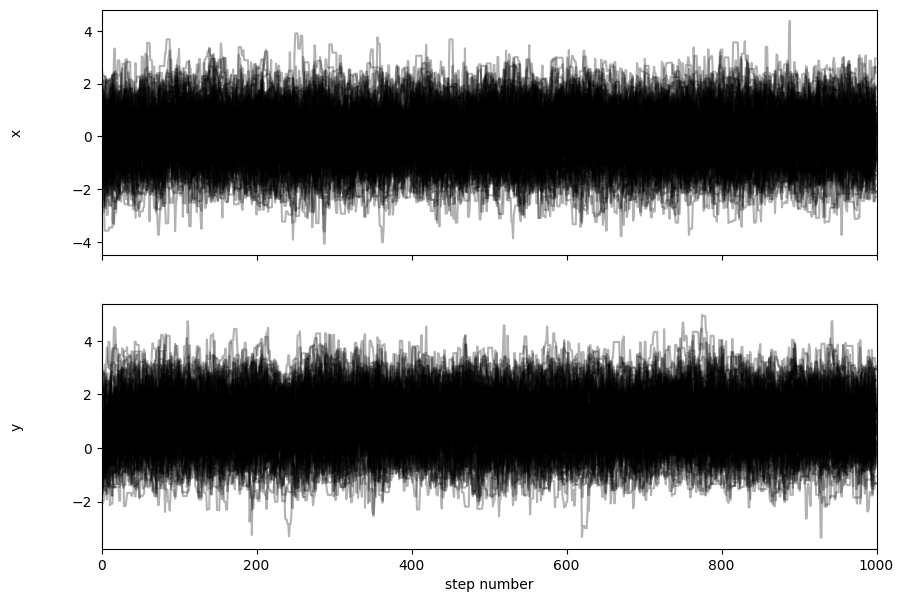

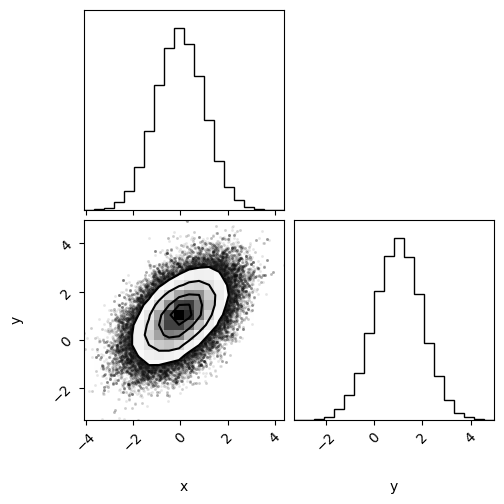

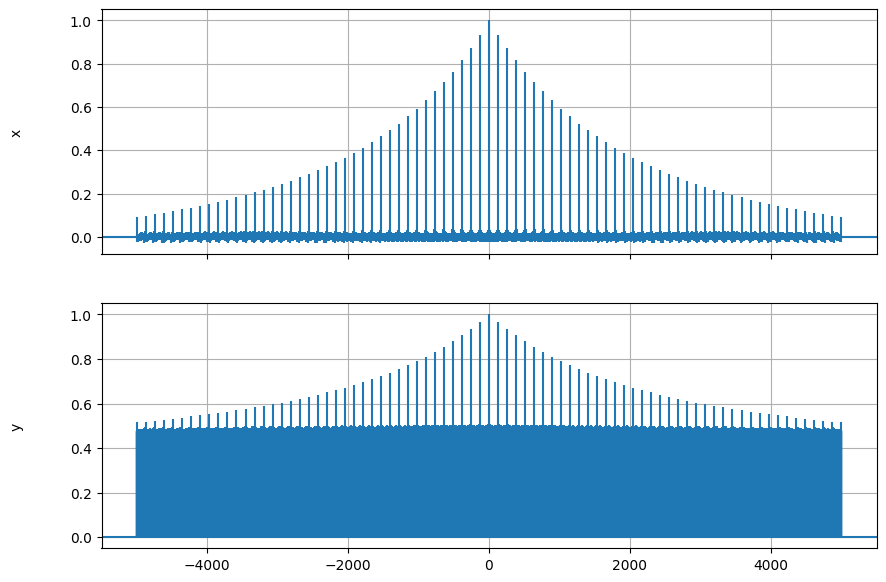

In [9]:
run_emcee(nwalkers,steps,ndim, [mean,var],log_prob1, 1)

### 2. Double bivariate Gaussian
Similar than the single bivariate Gaussian but with two peaks.

In [10]:
# 2nd target distribution
mean1 = np.array([0, 1])
var1 = np.array([[1, .5], [.5, 1]])
mean2 = np.array([-4,-4])
var2 = var1
def ptarget2(x, y):
    '''double Gaussian'''
    return 0.5 * (
          st.multivariate_normal.pdf([x, y], mean=mean1, cov=var1)
        + st.multivariate_normal.pdf([x, y], mean=mean2, cov=var2)
    )
def log_prob2(x, mean1, var1, mean2, var2):
    '''equivalent to ptarget2()'''
    return np.log ( 0.5 * (
          st.multivariate_normal.pdf(x, mean=mean1, cov=var1)
        + st.multivariate_normal.pdf(x, mean=mean2, cov=var2)
    ))

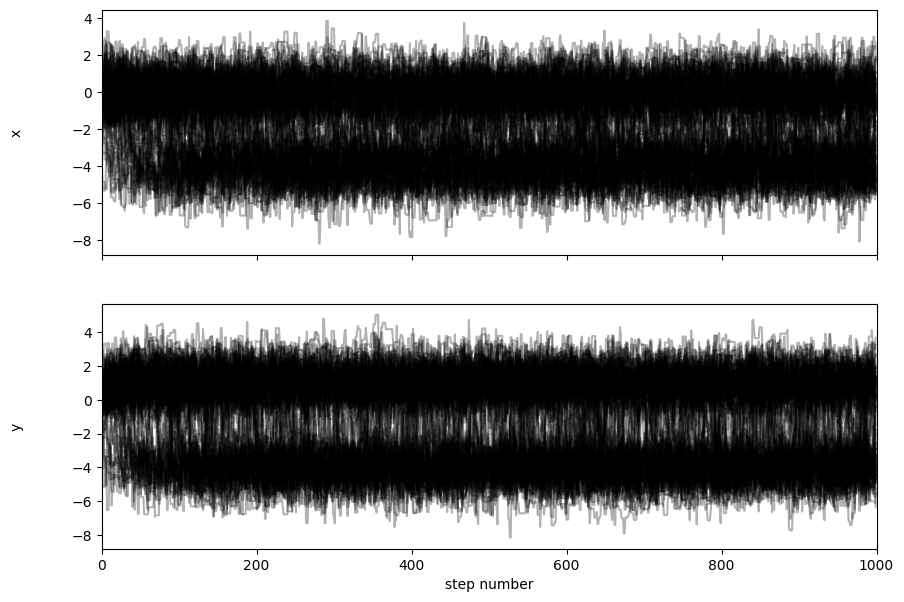

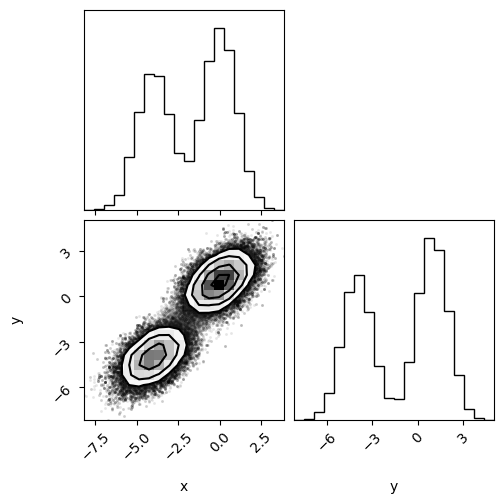

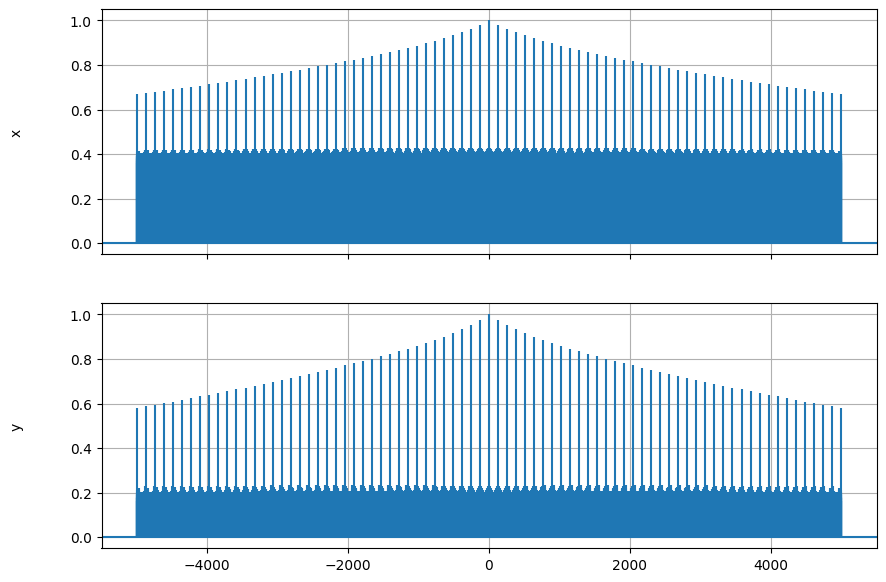

In [11]:
run_emcee(nwalkers,steps,ndim,[mean1,var1,mean2,var2],log_prob2,1)

### 3. Anisotropic distribution
Defined in Equation 2 of the paper https://arxiv.org/abs/1202.3665.
$$p(x)\propto f(-\frac{x_1-x_2)^2}{2\epsilon}-\frac{(x_1+x_2)^2}{2})$$

In [12]:
# 3rd target distribution
eps = 1e-6
def ptarget3(x, y):
    '''very anistropic distribution from Foreman-Mackey et al 2013, Eq. 2'''
    return np.exp(-(x-y)**2/(2*eps) - (x+y)**2/2)
def log_prob3(x, eps):
    '''equivalent to ptarget3()'''
    return -(x[0]-x[1])**2/(2*eps) - (x[0]+x[1])**2/2

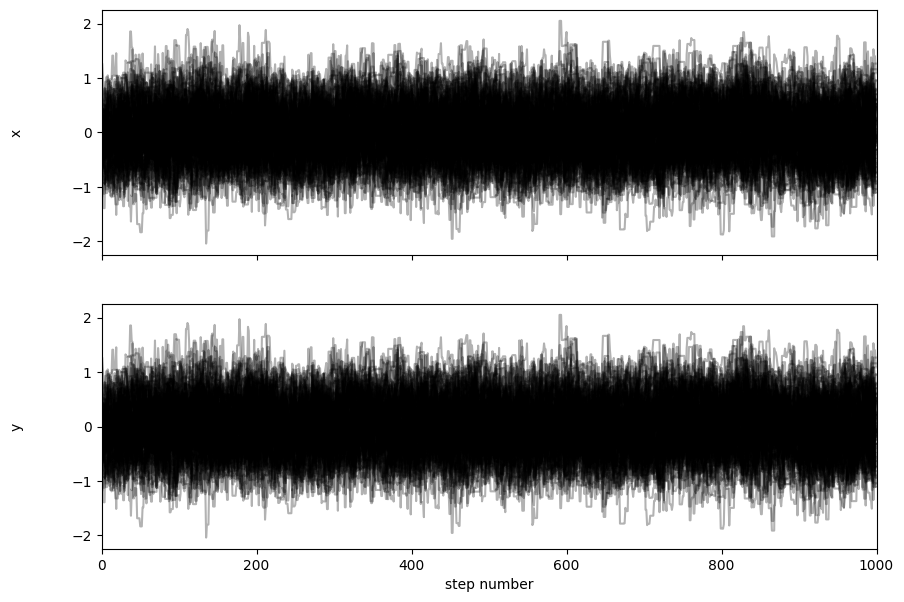

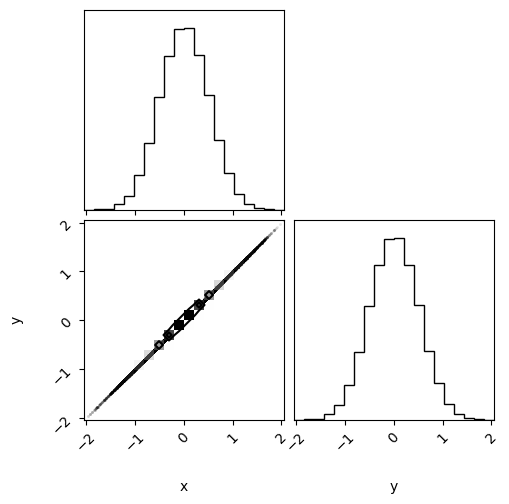

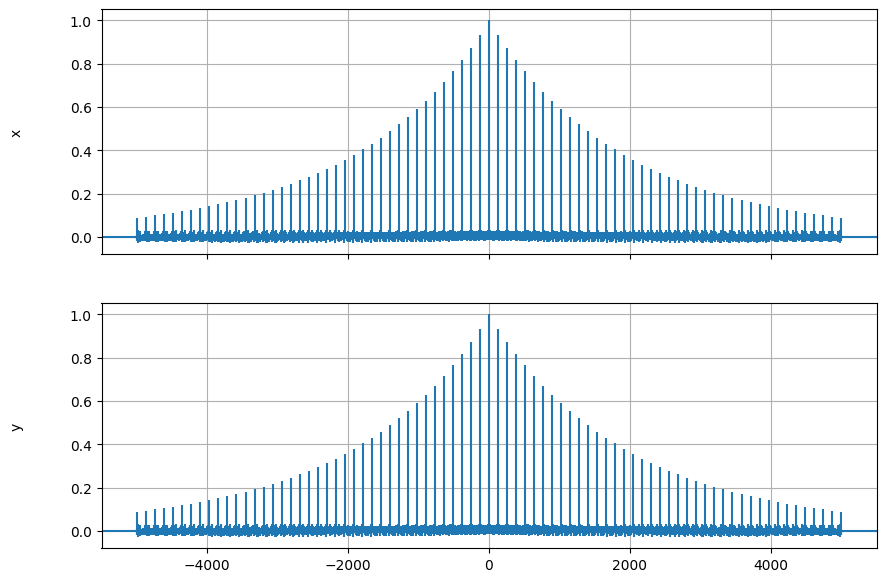

In [13]:
run_emcee(nwalkers,steps,ndim,[eps],log_prob3, 50)

Emcee proved to work  successfully for all three cases although the initial burn had to be increase from 1 to 50 for the anisotropic distribution case.

## 2. Parallel tempered Metropolis Hastings

The parallel tempered MCMC runs an ensemble of walkers with different temperature. The chains also exchange information between themselves. Use  "ptmcmcsampler".


In [32]:
def run_ptmh(steps, ndim, burn, loglike,logprior,args):
    pos = np.random.uniform(0, 10, ndim) #set start position
    
    sampler = PTMCMCSampler.PTSampler(ndim, logl=loglike, logp=logprior, cov=var,loglkwargs=args, outDir='./chains')
    sampler.sample(pos, steps, burn=burn, thin=1, covUpdate=500,
               SCAMweight=20, AMweight=20, DEweight=20)
    data = np.loadtxt('chains/chain_1.txt')
    chaint = data[:,:-4]

    # Plot the chains
    fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
    labels = ["x", "y"]
    ax1, ax2 = axes.flatten()
    
    ax1.plot(chaint[:, 0], "k", alpha=0.3)  # Assuming you want to plot the entire column '-4'
    ax1.set_xlim(0, len(chaint))  # Adjusted to chaint instead of data
    ax1.set_ylabel(labels[0])  # Assuming you want the first label
    ax1.yaxis.set_label_coords(-0.1, 0.5)
    
    ax2.plot(chaint[:, 1], "k", alpha=0.3)  # Adjusted for the second column '-3'
    ax2.set_xlim(0, len(chaint))  # Adjusted to chaint instead of data
    ax2.set_ylabel(labels[1])  # Assuming you want the second label
    ax2.yaxis.set_label_coords(-0.1, 0.5)
    
    axes[-1].set_xlabel("step number")
    plt.show()
    
    # Corner plot
    fig = corner.corner(chaint[burn:,:10], bins=50);
    plt.show()
    
    #Autocorrelation plots
    fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
    labels = ["x", "y"]
    for i in range(ndim):
        ax = axes[i]
        ax.acorr(chaint[:,i], maxlags=5000)
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
        ax.grid(True)


# Uniform prior distribution
def logprior(x):
    '''Uniform log prior distribution'''
    return 0.0

### 1. Single bivariate gaussian

Finished 0.00 percent in 0.001072 s Acceptance rate = 0Adding DE jump with weight 20
Finished 100.00 percent in 2.276103 s Acceptance rate = 0.52384
Run Complete


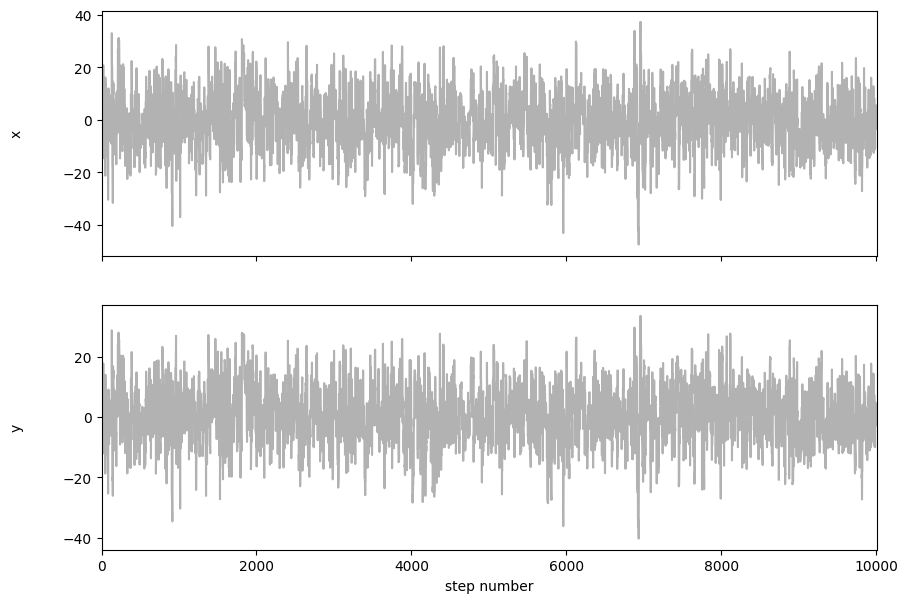

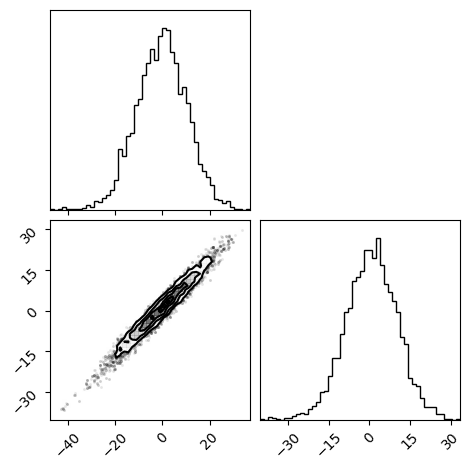

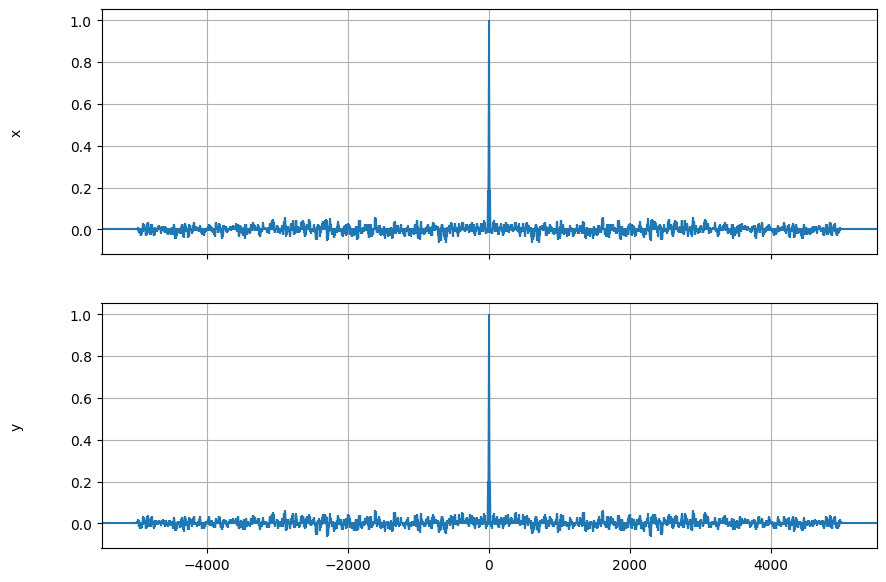

In [33]:
steps = 10000
ndim = 2

run_ptmh(steps, ndim, 500, log_prob1,logprior,{'mean':mean,'var':var})

### 2. Double bivariate gaussian

Finished 0.00 percent in 0.001065 s Acceptance rate = 0Adding DE jump with weight 20

/var/folders/7m/h14pp3yn7s75x_j82ksbgcsr0000gn/T/ipykernel_6345/982493679.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log ( 0.5 * (



Finished 100.00 percent in 3.809356 s Acceptance rate = 0.41222
Run Complete


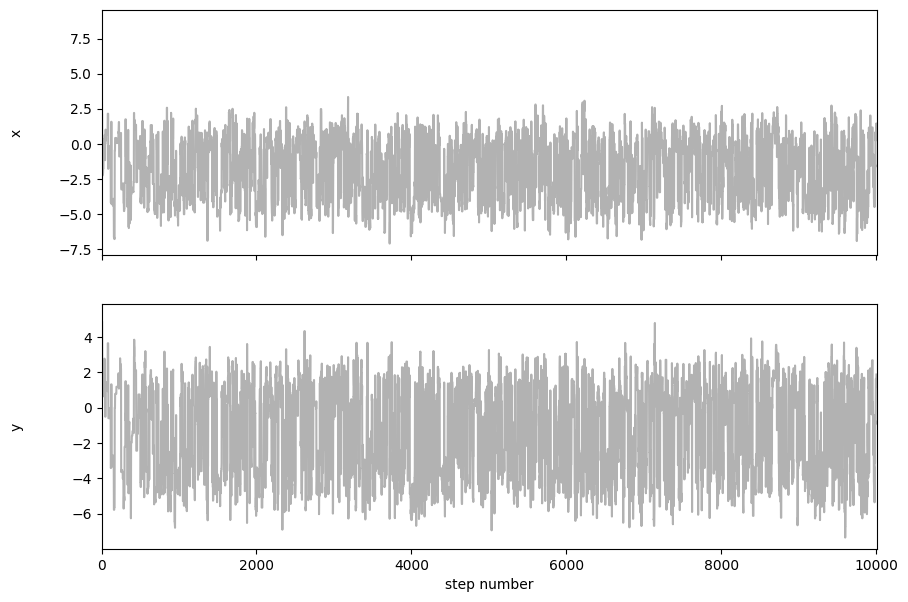

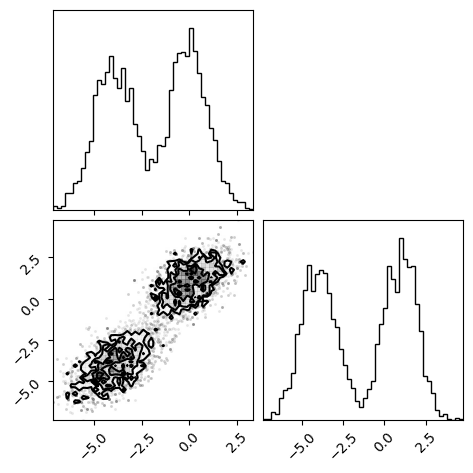

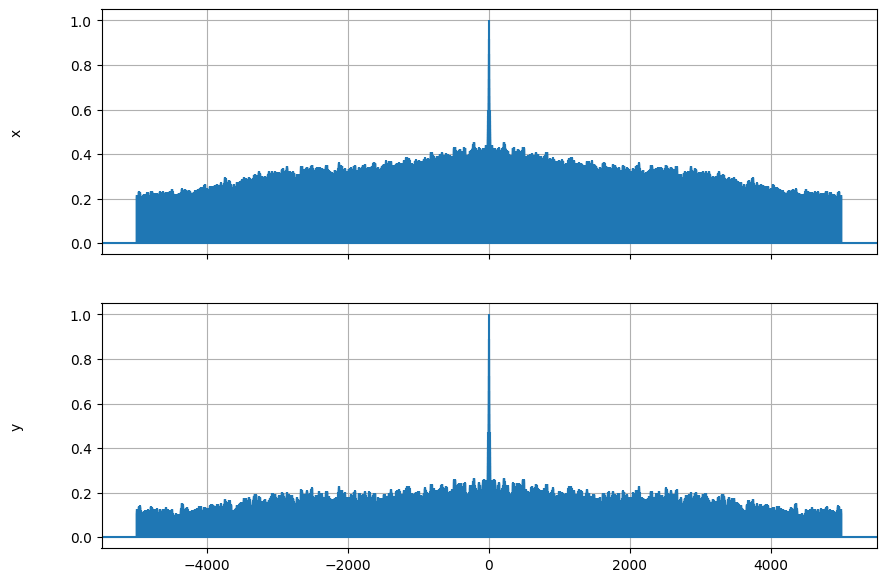

In [34]:
run_ptmh(steps, ndim, 500, log_prob2,logprior,
         {'mean1':mean1,'var1':var1,'mean2':mean2,'var2':var2})

### 3. The anisotropic distribution

Finished 20.00 percent in 0.140691 s Acceptance rate = 0.0225Adding DE jump with weight 20
Finished 100.00 percent in 0.636466 s Acceptance rate = 0.21433
Run Complete


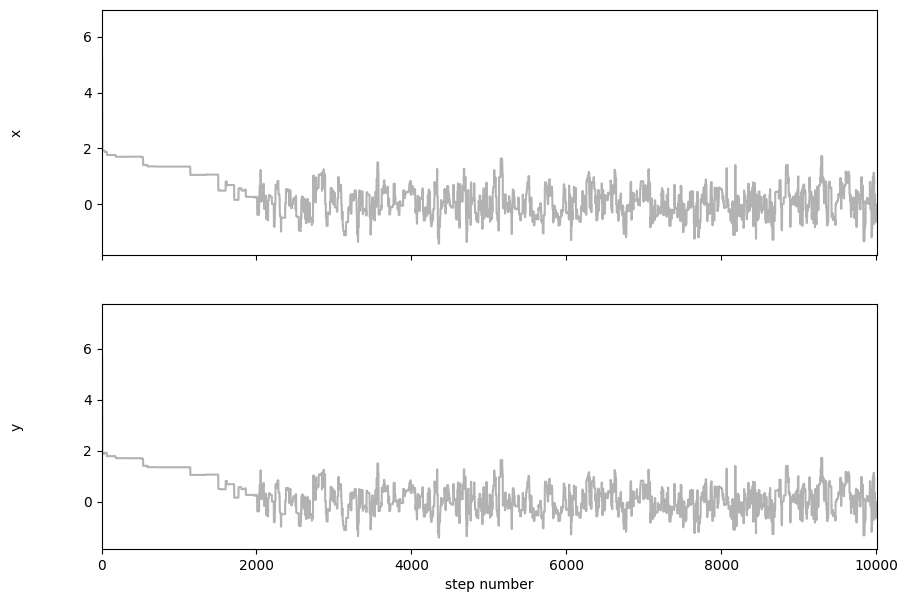

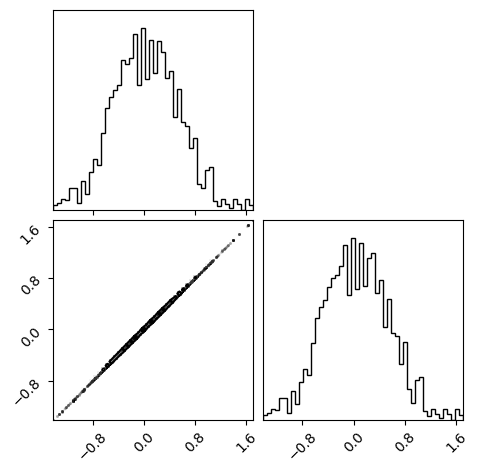

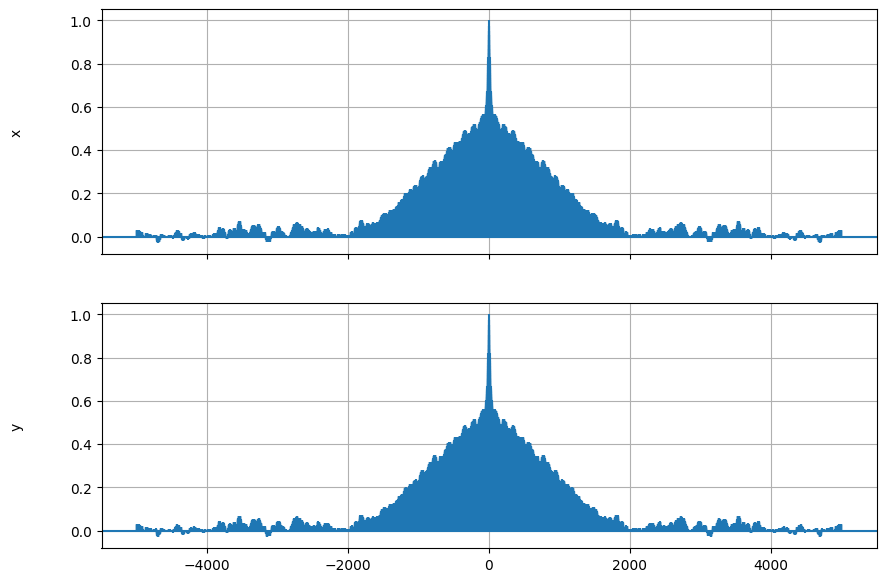

In [35]:
run_ptmh(steps, ndim, 2000, log_prob3,logprior,
         {'eps':eps})

Had to increase the burn-in period as the chains took longer to get to the correct distribution. Parallel tempered Metropolis Hastings worked successfully for all three cases.

## 3. Standard Metropolis-Hastings


In [40]:
# Standard Metropolis Hastings algorithm
def run_mh(
    target_function,
    initial_state,
    n_samples,
    proposal_std,
    maxlags,
):
    samples = [initial_state]
    current_state = initial_state
    acceptance = 0
    for _ in tqdm.tqdm(range(n_samples)):
        # Propose a new candidate state
        candidate_state = current_state+np.random.normal(
            scale=proposal_std,
            size=current_state.shape
        )
        # Calculate the acceptance ratio
        acceptance_ratio = min(
            1,
            target_function(*candidate_state)/target_function(*current_state)
        )
        # Accept or reject the candidate state
        if np.random.uniform() < acceptance_ratio:
            current_state = candidate_state
            acceptance += 1
        samples.append(current_state)
    samples = np.array(samples)
    
    # Plot the chains
    fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
    labels = ["x", "y"]
    ax1, ax2 = axes.flatten()
    ax1.plot(samples[:, 0], "k", alpha=0.3)  # Assuming you want to plot the entire column '-4'
    ax1.set_xlim(0, len(samples))  # Adjusted to chaint instead of data
    ax1.set_ylabel(labels[0])  # Assuming you want the first label
    ax1.yaxis.set_label_coords(-0.1, 0.5)
    
    ax2.plot(samples[:, 1], "k", alpha=0.3)  # Adjusted for the second column '-3'
    ax2.set_xlim(0, len(samples))  # Adjusted to chaint instead of data
    ax2.set_ylabel(labels[1])  # Assuming you want the second label
    ax2.yaxis.set_label_coords(-0.1, 0.5)
    
    # Corner plot
    fig = corner.corner(samples.reshape((-1, ndim)),bins=50);
    plt.show()
    
    #Autocorrelation plots
    fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
    labels = ["x", "y"]
    for i in range(ndim):
        ax = axes[i]
        ax.acorr(samples[:,i], maxlags=5000)
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
        ax.grid(True)


### 1. Single bivariate gaussian

  0%|                                                 | 0/25000 [00:00<?, ?it/s]/var/folders/7m/h14pp3yn7s75x_j82ksbgcsr0000gn/T/ipykernel_6345/3012098323.py:21: RuntimeWarning: invalid value encountered in scalar divide
  target_function(*candidate_state)/target_function(*current_state)
 41%|██████████████▍                    | 10295/25000 [00:03<00:04, 3340.52it/s]/var/folders/7m/h14pp3yn7s75x_j82ksbgcsr0000gn/T/ipykernel_6345/3012098323.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  target_function(*candidate_state)/target_function(*current_state)
100%|███████████████████████████████████| 25000/25000 [00:07<00:00, 3418.36it/s]


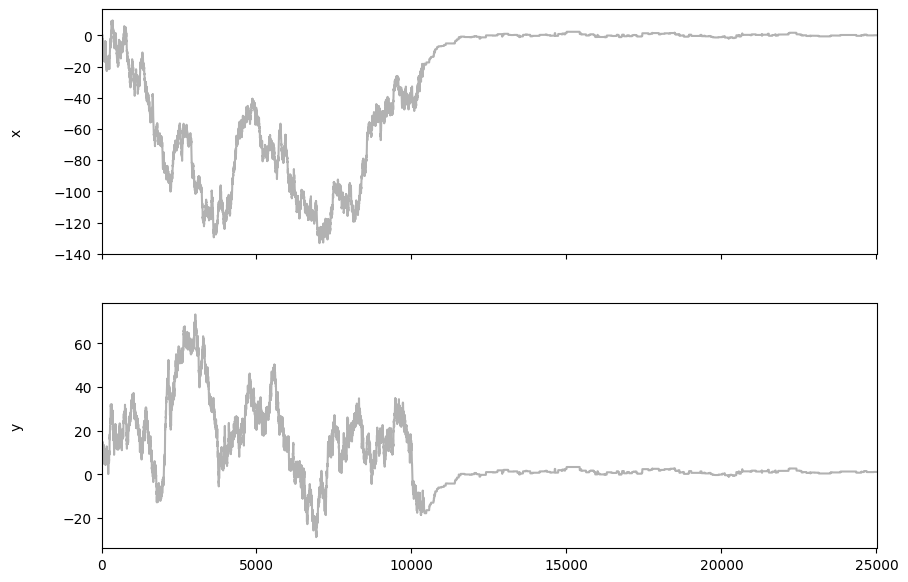

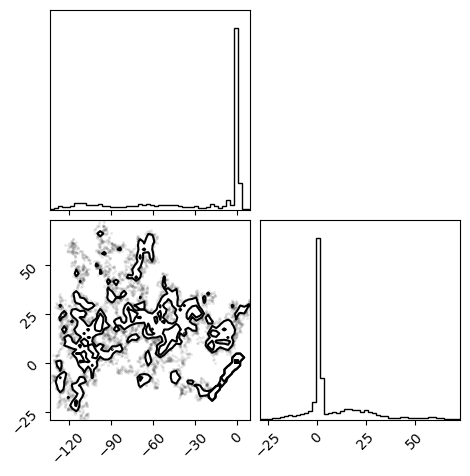

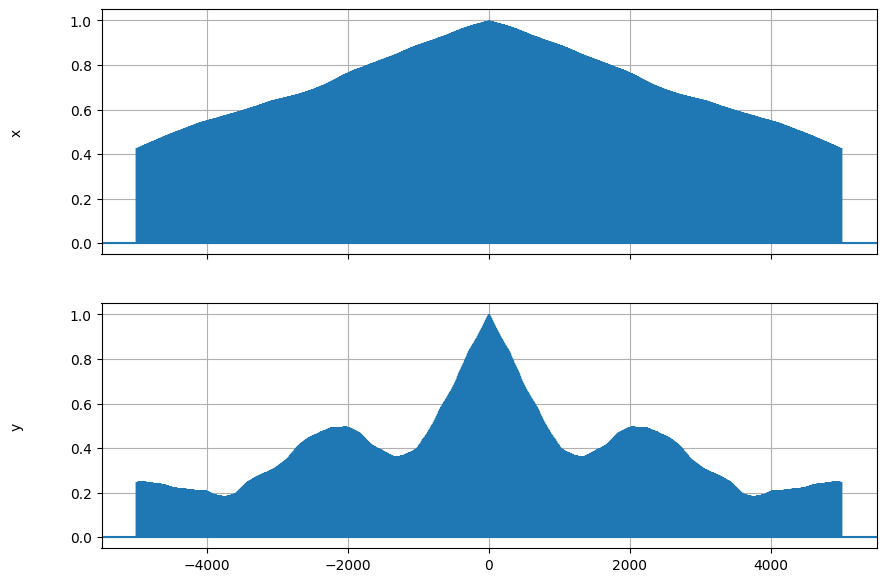

In [41]:
run_mh(
    ptarget1,
    initial_state=np.array([-5, 5]),
    n_samples=25000,
    proposal_std=1.0,
    maxlags=1000)

### 2. Double bivariate gaussian

100%|███████████████████████████████████| 25000/25000 [00:13<00:00, 1812.99it/s]


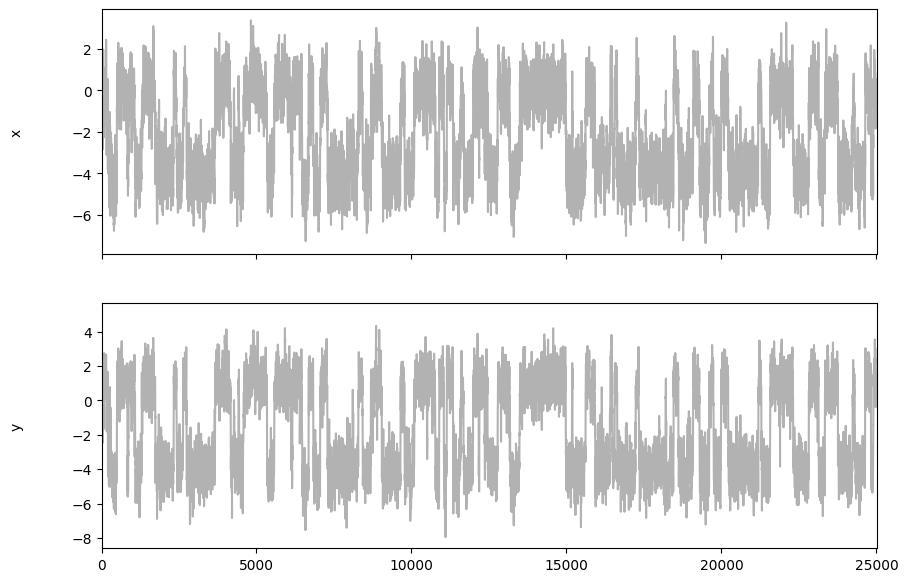

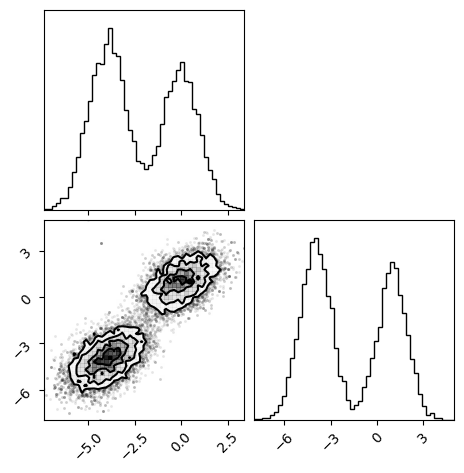

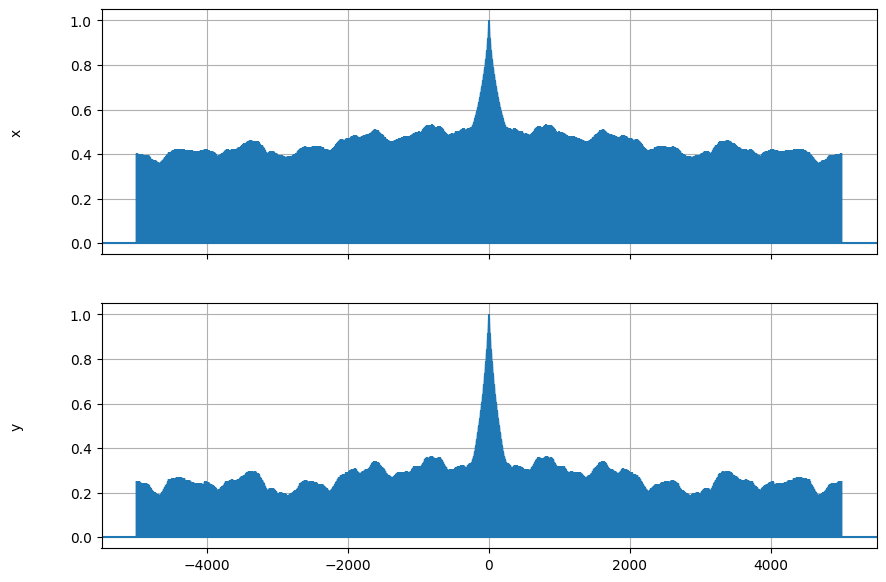

In [38]:
run_mh(
    ptarget2,
    initial_state=np.array([-5, 5]),
    n_samples=25000,
    proposal_std=1.0,
    maxlags=1000)

### 3. Anisotropic distribution

  0%|                                                 | 0/25000 [00:00<?, ?it/s]/var/folders/7m/h14pp3yn7s75x_j82ksbgcsr0000gn/T/ipykernel_6345/2865788264.py:21: RuntimeWarning: invalid value encountered in scalar divide
  target_function(*candidate_state)/target_function(*current_state)
/var/folders/7m/h14pp3yn7s75x_j82ksbgcsr0000gn/T/ipykernel_6345/2865788264.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  target_function(*candidate_state)/target_function(*current_state)
100%|██████████████████████████████████| 25000/25000 [00:00<00:00, 80728.25it/s]


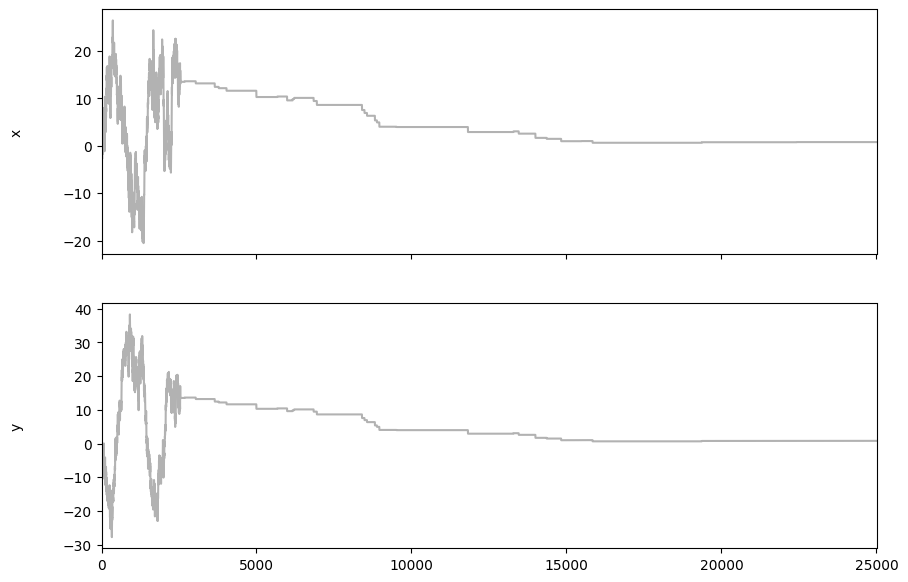

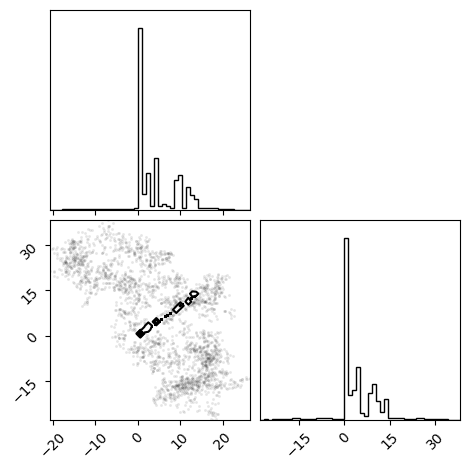

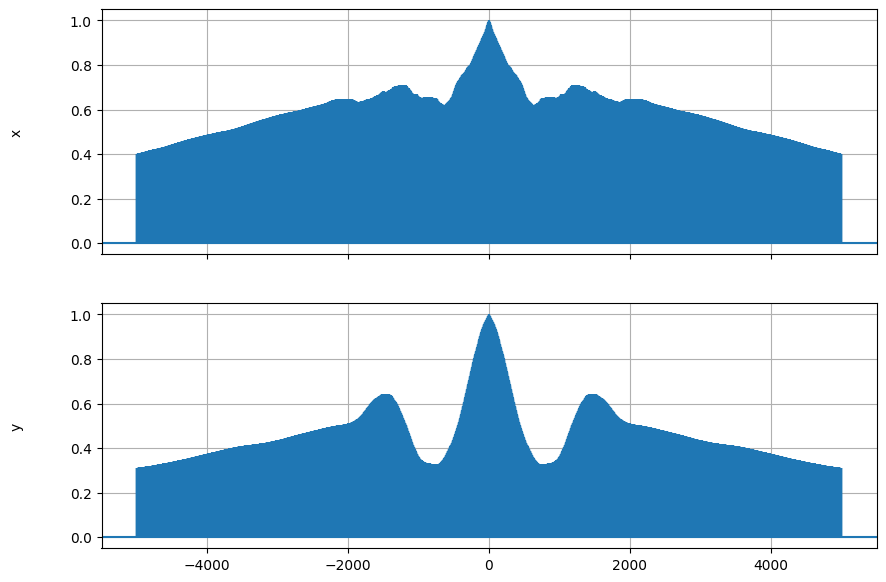

In [39]:
run_mh(
    ptarget3,
    initial_state=np.array([-5, 5]),
    n_samples=25000,
    proposal_std=1.0,
    maxlags=1000)

Standard Metropolis-Hastings worked for the double bivariate Gaussian cases but didn't showcase proper posterior distributions for the single bivariate Gaussian and the anisotropic distribution.
